# Assignment 5

Explore embeddings and CNN

Using tweeter dataset ( https://www.kaggle.com/utathya/sentiment-analysis-of-imdb-reviews/data) and already existing splitting on train/test sets, develop a model for sentiment analysis.  
Your quality metric is crossentropy (`sklearn.metrics.log_loss`, `torch.nn.CrossEntropy`)  

Your model should be based on CNN and written in pytorch `torch.nn.Conv1d`.

Explore 3 ways, which of them has better perfomance on test set?:
1. Using pretrained word embeddings with frozen weights. `torch.nn.Embedding.from_pretrained(embed_matrix, frozen=True)`.
You can download any pretrained embeddings you like.
2. Train embeddings yourself, initializing from pretrained weights. `torch.nn.Embedding.from_pretrained(embed_matrix, frozen=False)`
3. Train embeddings yourself with random initialization `torch.nn.init.uniform_(nn.Embeddings.weights)`

Experiment with model arhitecture (as bonus):
1. activation functions RELU, ELU, etc `torch.nn.functional.relu, torch.nn.functional.elu`  
1. Stack layers
1. max or average pooling (`torch.nn.functional.max_pool1d, torch.nn.functional.avg_pool1d`)
1. Dropout


Other requirements:
1. Your training routine should use any learning scheduler (torch.nn.optim.lr_scheduler).  
Plot current learning rate against number of epochs, e.g. `tt.optim.Adam.param_groups[0]['lr']`.  

1. Your training routine should use early stopping on validation dataset
Use hold out validation scheme in your experiments.

1. You should use torchtext for parsing 

**Note**:
This assignment has no baseline. Instead, **validation curves** for explored architectures are expected.  
Validation curve is plot of model test score against model hyperparameter value.  
example (https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html) . 
Though, using `sklearn.model_selection.validation_curve` is not necessary.  






In [0]:
import pandas as pd
import numpy as np
from sklearn.externals import joblib
import gensim

from sklearn import metrics

from nltk.tokenize import TweetTokenizer
from nltk.stem import SnowballStemmer
from string import punctuation

import torch as tt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

from torchtext.data import Field, LabelField, RawField, BucketIterator, TabularDataset

import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)

punctuation += '«»—…“”№–'

Загрузим "stop_words" для доступа к расширенному списку стоп-слов.

In [3]:
!pip install stop-words

from stop_words import get_stop_words

stop_words_list = get_stop_words('english')

  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


In [5]:
df = pd.read_csv('imdb_master.csv',  encoding='ISO-8859-1')
df.head()

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [0]:
train_df = df[df.type == 'train']
test_df = df[df.type == 'test']

train_df = train_df[train_df.label != 'unsup']

pd.DataFrame.to_csv(train_df, 'imdb_train.csv', index=False)
pd.DataFrame.to_csv(test_df, 'imdb_test.csv', index=False)

In [0]:
nltk_tokenizer = TweetTokenizer()
nltk_stemmer = SnowballStemmer('english')

def tokenizer(text):
  
    tokens = nltk_tokenizer.tokenize(nltk_stemmer.stem(text))
    result = [word.strip(punctuation) for word in tokens]
    
    return [word for word in result if word.strip(punctuation) != '']

In [0]:
classes = {'neg' : 0,
           'pos' : 1
          }

TEXT = Field(include_lengths=True,
             batch_first=True, 
             tokenize=tokenizer,
             eos_token='<eos>',
             lower=True,
             stop_words=stop_words_list)


LABEL = LabelField(dtype=tt.int64,
                   use_vocab=True,
                   preprocessing=lambda x: classes[x])

fields_list = [(None, None),
               (None, None),
               ('review', TEXT),
               ('label', LABEL),
               (None, None)]
                               
train = TabularDataset('imdb_train.csv',
                       format='csv',
                       fields=fields_list,
                       skip_header=True)

test = TabularDataset('imdb_test.csv',
                      format='csv',
                      fields=fields_list,
                      skip_header=True)

In [9]:
TEXT.build_vocab(train, vectors="glove.6B.100d")

.vector_cache/glove.6B.zip: 862MB [02:32, 5.66MB/s]                           
100%|█████████▉| 398275/400000 [00:20<00:00, 19088.53it/s]

In [0]:
embed_matrix = TEXT.vocab.vectors

In [0]:
LABEL.build_vocab(train)

In [0]:
train, valid = train.split(0.7, stratified=True)

Пострим нашу модель. Я сразу создам атрибут, который будет показывать какой embedding мы используем в данный момент, а также постараемся поработать с dropout

In [0]:
class CNNModel(nn.Module):
  
  
  def __init__(self, vocab_size, embed_size, embed_matrix, hidden_size, kernels, mode, n_epochs=5):
    
    super(CNNModel, self).__init__()
    
    if mode == 'pretrained':
      self.embedding = nn.Embedding.from_pretrained(embed_matrix,
                                                    freeze=True)
    elif mode == 'weights':
      self.embedding = nn.Embedding.from_pretrained(embed_matrix,
                                                    freeze=False)
    elif mode == 'random':
      self.embedding = nn.Embedding.from_pretrained(nn.init.uniform_(tt.ones((vocab_size,100))),
                                                    freeze=False)
    self.n_epochs = n_epochs
    self.convs = nn.ModuleList([nn.Conv1d(embed_size, hidden_size, k, padding=5) for k in kernels])
    self.fc = nn.Linear(hidden_size * len(kernels), 3)
  
  
  def forward(self, x):
    
    x = self.embedding(x)
    x = x.transpose(1,2)
    
    concatenated = []
    for conv in self.convs:
      z = conv(x)
      z = F.avg_pool1d(z, kernel_size=z.size(2))
      z = z.squeeze(2)
      concatenated.append(z)
      
    x = tt.cat(concatenated, 1)
    x = self.fc(x)
  
    return x
  
  
  def train(self, train_iterator, valid_iterator, optimizer, scheduler, criterion):
    
    history = []
    all_train_losses = []
    all_valid_losses = []
    min_loss = np.inf
    no_improvement = 0
        
    for epoch in range(self.n_epochs):
            
      train_losses = []
      valid_losses = []
      
      for batch in train_iterator:
                        
        optimizer.zero_grad()
        
        train_pred = self.forward(batch.review[0])
        train_loss_crit = criterion(train_pred, batch.label)
        train_losses.append(train_loss_crit.item())
        
        train_loss_crit.backward()
        optimizer.step()
        
      mean_train_loss = np.mean(train_losses)
      all_train_losses.append(mean_train_loss)
        
      with tt.no_grad():
        
        for valid_batch in valid_iterator:
          
          
          valid_pred = self.forward(valid_batch.review[0])
          valid_loss_crit = criterion(valid_pred, valid_batch.label)
          valid_losses.append(valid_loss_crit.item())
          
        mean_valid_loss = np.mean(valid_losses)
        all_valid_losses.append(mean_valid_loss)
        
      if mean_valid_loss < min_loss:
        min_loss = mean_valid_loss
        no_improvement = 0
        
      elif no_improvement < scheduler.patience:
        no_improvement += 1
        
      else:
        print('Training stoped on (%dth epoch)' % (epoch + 1))
        break
      
      history.append(optimizer.param_groups[0]['lr'])
      scheduler.step(mean_valid_loss)
                
      print('Epoch – %s | Train loss – %s | Validation loss – %s\n' % (str(epoch + 1),
                                                                     float(np.mean(train_losses)),
                                                                     float(np.mean(valid_losses))))
    
    return history, all_train_losses, all_valid_losses
    
  
  def evaluate(self, test_iterator, criterion):
    
    epoch_loss = []
    
    with tt.no_grad():
      
      for batch in test_iterator:
        
        test_pred = self.forward(batch.review[0])
        epoch_loss.append(criterion(test_pred, batch.label))
                    
    return np.mean(epoch_loss)

In [0]:
tt.cuda.empty_cache()

batch_size = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train, valid, test),
    batch_sizes=(batch_size, batch_size, batch_size),
    shuffle=True,
    sort_key=lambda x: len(x.review)
)

Напишем функции для построения графиков и в конце каждого обучения будем визуализировать результат

Epoch – 1 | Train loss – 0.698841559930519 | Validation loss – 0.48634753379415957

Epoch – 2 | Train loss – 0.40198470446429263 | Validation loss – 0.4984747839576386

Epoch – 3 | Train loss – 0.23815789822849975 | Validation loss – 0.5856768020369271

Epoch – 4 | Train loss – 0.18201584971324292 | Validation loss – 0.6199713258033103

Training stoped on (5th epoch)
 

 Model mode – random 

 Test Loss – 0.84470457 

 Plots:


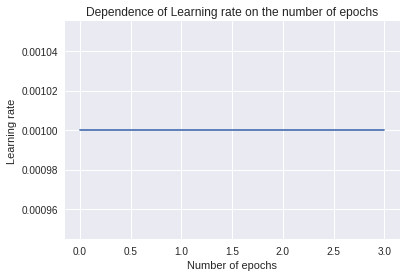

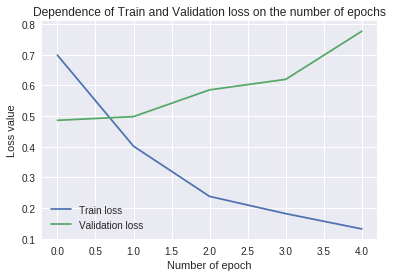

Epoch – 1 | Train loss – 0.5507148809908077 | Validation loss – 0.7159183264412778

Epoch – 2 | Train loss – 0.499104453778572 | Validation loss – 0.7263873551754241

Epoch – 3 | Train loss – 0.48575600545846565 | Validation loss – 0.6765163576983391

Epoch – 4 | Train loss – 0.4818032295655943 | Validation loss – 0.7601090840202697

Epoch – 5 | Train loss – 0.4788055210978719 | Validation loss – 0.822935859763876

Epoch – 6 | Train loss – 0.47744513843787434 | Validation loss – 0.7030154477408592

Training stoped on (7th epoch)
 

 Model mode – pretrained 

 Test Loss – 0.66079223 

 Plots:


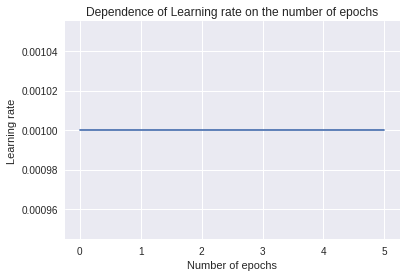

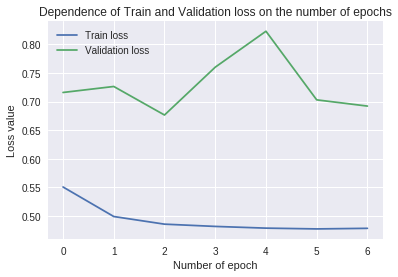

Epoch – 1 | Train loss – 0.45865138828536495 | Validation loss – 0.5736326217334321

Epoch – 2 | Train loss – 0.23309363944411712 | Validation loss – 0.7248286818570279

Epoch – 3 | Train loss – 0.1301942693454365 | Validation loss – 0.8459956784514671

Epoch – 4 | Train loss – 0.07378990454616287 | Validation loss – 1.169898011202508

Training stoped on (5th epoch)
 

 Model mode – weights 

 Test Loss – 1.9117457 

 Plots:


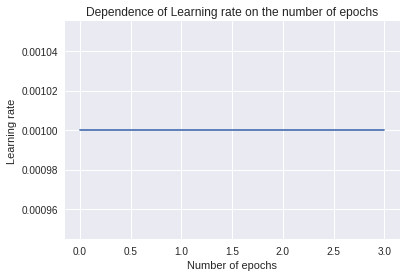

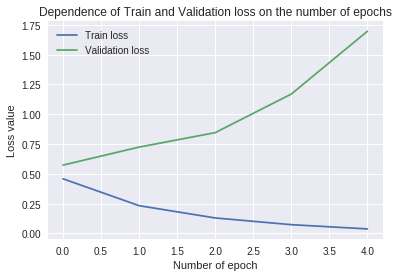

In [16]:
train_results = []
evaluate_results = []

def plot_learning_rate(model_history):
  plt.plot(range(len(model_history)), model_history)
  plt.xlabel('Number of epochs')
  plt.ylabel('Learning rate')
  plt.title('Dependence of Learning rate on the number of epochs')
  plt.show()

def plot_model_losses(train_losses, val_losses):
  plt.plot(range(len(train_losses)), train_losses, label='Train loss')
  plt.plot(range(len(val_losses)), val_losses, label='Validation loss')
  plt.xlabel('Number of epoch')
  plt.ylabel('Loss value')
  plt.title('Dependence of Train and Validation loss on the number of epochs')
  plt.legend()
  plt.show()
  
for mode in ['random', 'pretrained', 'weights']:
  
  tt.cuda.empty_cache()
  
  model = CNNModel(len(TEXT.vocab.itos),
                   embed_size=100,
                   embed_matrix=embed_matrix,
                   hidden_size=128,
                   kernels=[2,3,4,5],
                   mode=mode,
                   n_epochs=100)
  
  optimizer = optim.Adam(model.parameters())
  
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   patience=3,
                                                   verbose=True, 
                                                   cooldown=5)
  criterion = nn.CrossEntropyLoss()
  
  train_result = model.train(train_iterator, valid_iterator, optimizer, scheduler, criterion)
  train_results.append(train_result)
  
  evaluate_result = model.evaluate(test_iterator, criterion)
  evaluate_results.append(evaluate_result)

  print(' \n\n Model mode – %s \n\n Test Loss – %s \n\n Plots:' % (str(mode),
                                                                   str(evaluate_result)))
  plot_learning_rate(train_result[0])
  plot_model_losses(train_result[1], train_result[2])

На удивление leatning rate оказался статиным, что напрягает, но судя по всему это происходит из-за раннего обучения на малом количестве эпох.

Теперь давайте выведем финальный результат для всех трех моделей и сделаем выводы.

In [0]:
def all_embeddings_plot(test_results):
  plt.figure(figsize=(10,7))
  plt.plot(['Trained embeddings yourself with random initialization',
            'Pretrained word embeddings with frozen weights',
            'Trained embeddings, initializing from pretrained weights'],
           [test_results[0],
            test_results[1],
            test_results[2]])
  plt.xlabel('Types of embeddings')
  plt.ylabel('Crossentropy Loss')
  plt.title('Validation curve')

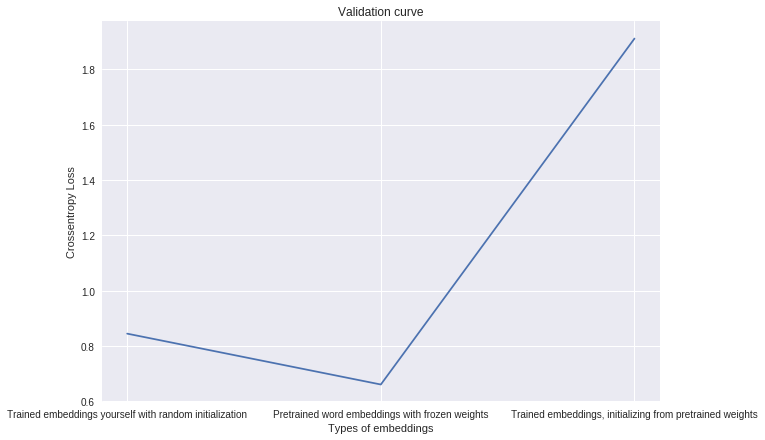

In [26]:
all_embeddings_plot(evaluate_results)

Как можно заметить, что лучше всего себя показали уже предобученные вектора, поэтому вместо того, чтобы обучать embaddings самим, лучше уже обученный embadding с фиксированными весами.